# I. Algorithm

In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [66]:
# Defining the Euclidean distance function - Will Be Default
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Manhattan Distance 
def manhattan_distance(point1, point2):
    return np.abs(point1[0]-point2[0]) + np.abs(point1[1]-point2[1])

# Returns the coordinates of the centroid given the np array cluster, which lists the coordinates of the points in a cluster
def calculate_centroid(cluster):
    centroid = np.mean(cluster, axis=0)
    return centroid

# Given data and centroids, assigns each point to an array in the output clusters
def assign_clusters(data, centroids, distance):
    clusters = [[] for i in centroids] # Initialize empty list of lists for clusters
    for point in data:
        distances = [distance(point, centroid) for centroid in centroids]
        closest_index = np.argmin(distances)
        clusters[closest_index].append(point)
    return clusters

# Returns the coordinates of the new centroids
def update_centroids(clusters):
    return np.array([calculate_centroid(np.array(cluster)) for cluster in clusters])

# Checks if newly calculated centroids have changed within a tolerance level 
def has_converged(old_centroids, new_centroids, tol=1e-4):
    # Compute the distance between corresponding centroids
    centroid_diff = np.linalg.norm(old_centroids - new_centroids, axis=1)

    if old_centroids.shape != new_centroids.shape:
        raise ValueError(f"Shape mismatch: old_centroids has shape {old_centroids.shape}, new_centroids has shape {new_centroids.shape}")
    
    # Check if all the distances are below the tolerance
    return np.all(centroid_diff < tol)

# Puts all the helper functions together and implements k-means clustering

def k_means(data, k, distance_function, max_iters = 100):
    """
    Performs k-means clustering 

    Inputs: data: numpy array where each row is a data point
            k: The number of clusters
            max_iters: Max number of iterations of algorithm, default is 100
            distance: the distance function used
    Output: centroids: numpy array where each row is a centroid of a cluster
            clusters: a list of lists that gives the coordinates of each point in the cluster
    """

    indices = np.random.choice(len(data), k, replace=False)
    centroids = data[indices]

    for iter in range(max_iters):
        clusters = assign_clusters(data, centroids, distance_function)
        new_centroids = update_centroids(clusters)
        if has_converged(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, clusters

# Computes the Within-Cluster Sum of Squares

def compute_wcss(clusters, centroids, distance_function):
    """
    Computes the Within-Cluster Sum of Squares (WCSS)
    
    Inputs:
        clusters: List of clusters, each containing the points in that cluster.
        centroids: numpy array that gives centroids of the clusters 
    
    Output:
        The WCSS value.
    """
    wcss = 0
    k = len(clusters)  # Number of clusters
    
    for i in range(k):
        cluster_points = clusters[i]  # Points in the i-th cluster
        centroid = centroids[i]  # Centroid of the i-th cluster
        
        # Calculate the sum of squared distances from each point in the cluster to the centroid
        cluster_wcss = np.sum([distance_function(point, centroid) ** 2 for point in cluster_points])
        wcss += cluster_wcss
    
    return wcss


# II. Application to Data Set

Suppose you are planning a road trip to visit some roller coasters in the United States. You want to hit the most amount of roller coasters while also being efficient with travel distance. Where should you go?

To answer this question, we will use k-Means Clustering to cluster our roller coasters into clusters based on their coordinate location (longitude and latitude).

First, we will do some data cleaning.

In [13]:
coaster_data = pd.read_csv("../coaster_db.csv")

cleaned_data = coaster_data[['coaster_name','latitude','longitude']]

cleaned_data.dropna

cleaned_data.head(5)

,coaster_name,latitude,longitude
0,Switchback Railway,40.5740,-73.9780
1,Flip Flap Railway,40.5780,-73.9790
2,Switchback Railway (Euclid Beach Park),41.5800,-81.5700
3,Loop the Loop (Coney Island),40.5745,-73.9780
4,Loop the Loop (Young's Pier),39.3538,-74.4342


Our data does not explicitly say if a roller coaster is in the United States or not. However, we do know that continental U.S. is bound between latitudes from roughly 25° to 49° North and longitudes from 60° to 125° West. Note that West corresponds to negative longitudes.

In [20]:
# Restricting Data to U.S. roller coasters based on longitude and latitude
continental_us = cleaned_data[
    (cleaned_data['latitude'] >= 25) & (cleaned_data['latitude'] <= 49) &
    (cleaned_data['longitude'] >= -125) & (cleaned_data['longitude'] <= -60)
]

print(f"The number of roller coasters in Continental US is {len(continental_us)}.")

The number of roller coasters in Continental US is 514.


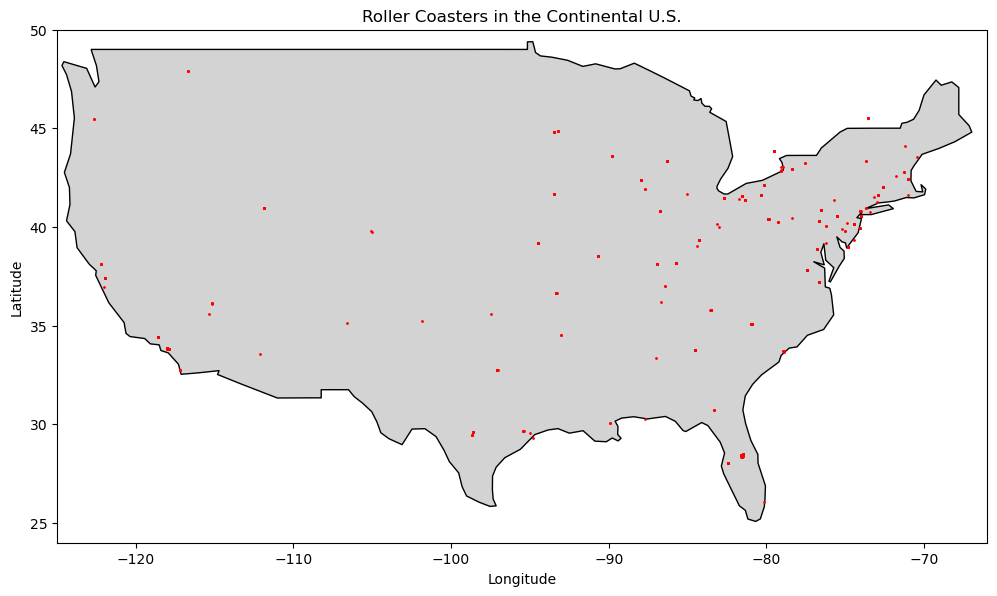

In [21]:
# Create geometry from longitude and latitude
geometry = [Point(xy) for xy in zip(continental_us['longitude'], continental_us['latitude'])]
geo_df = gpd.GeoDataFrame(continental_us, geometry=geometry, crs='EPSG:4326')  # WGS 84

# Load the built-in low-resolution world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for United States
usa = world[world['name'] == 'United States of America']

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
usa.plot(ax=ax, color='lightgray', edgecolor='black')
geo_df.plot(ax=ax, color='red', markersize=1)

# Set bounds for continental U.S.
ax.set_xlim(-125, -66)   # Longitude
ax.set_ylim(24, 50)      # Latitude

plt.title('Roller Coasters in the Continental U.S.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



In [71]:
us_coasters_coordinates = continental_us[['longitude','latitude']].to_numpy() # Only Looking at Coordinates
us_centroids_k, us_clusters_k = k_means(us_coasters_coordinates, k = 28, distance_function=euclidean_distance, max_iters = 300)
wcss_k = compute_wcss(us_clusters_k, us_centroids_k, euclidean_distance)


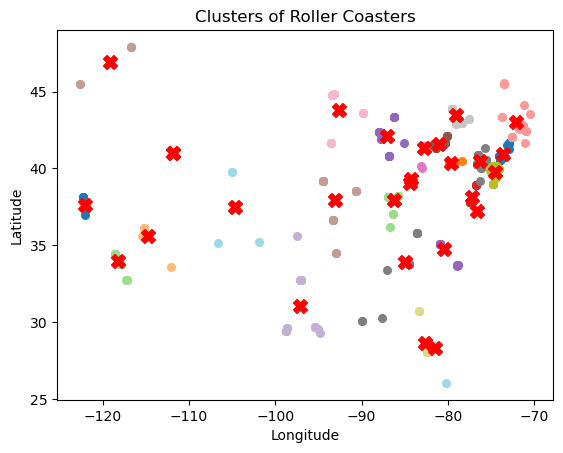

In [72]:
def plot_clusters(data, clusters, centroids):
    """
    Plots the data points with each cluster having its own color and centroids marked.

    Inputs:
        data: numpy array of data points (e.g., (n_points, 2) for 2D data)
        clusters: list of clusters, where each cluster is a list of points assigned to that cluster
        centroids: numpy array of centroids (e.g., (k, 2) for 2D centroids)
    """
    # Number of clusters
    k = len(clusters)

    # Generate colors for each cluster
    colors = plt.cm.get_cmap('tab20', k)  # 'tab20' is a colormap with 20 distinct colors

    # Plot each cluster with a different color
    for i in range(k):
        cluster_points = np.array(clusters[i])
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors(i)], label=f'Cluster {i+1}', s=30)

    # Plot the centroids as large red points
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Clusters of Roller Coasters')

    # Display the plot
    plt.show()

# Assuming you have the following variables:
# us_coasters_coordinates = Data points (longitude, latitude)
# us_clusters_k = The clusters (list of points for each cluster)
# us_centroids_k = The centroids (k, 2) array of centroids

plot_clusters(us_coasters_coordinates, us_clusters_k, us_centroids_k)

As you can see, roller coasters are sparsely located around the United States. There is definitley a lot of clusters in the Northeast and the Midwest. Now, let's apply the k-Means-Clustering Algorithm. We will apply the elbow-method to determine the optimal $k$ value.

In [47]:
us_coasters_coordinates = continental_us[['longitude','latitude']].to_numpy() # Only Looking at Coordinates

# Elbow Method

wcss_values = []

for k_value in range(1,150):
    # Running algorithm for each value of k
    print(k_value)
    us_centroids_k, us_clusters_k = k_means(us_coasters_coordinates, k = k_value, distance_function=euclidean_distance, max_iters = 100)
    wcss_k = compute_wcss(us_clusters_k, us_centroids_k, euclidean_distance)
    wcss_values.append(wcss_k)

# Plotting
# plt.plot(range(1, 101), wcss_values, marker='o')
# plt.title('WCSS vs. Number of Clusters (k)')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('WCSS')
# plt.show()

print(wcss_k)






1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


/Users/jonathancheng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jonathancheng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/xh/x976_5p93059y1sn4ybh8ql40000gn/T/ipykernel_9066/3092959299.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([calculate_centroid(np.array(cluster)) for cluster in clusters])


ValueError: operands could not be broadcast together with shapes (26,2) (26,) 